In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
data = pd.read_csv("/content/trum_tweet_sentiment_analysis (1).csv")


In [ ]:
print("Original dataset size:", data.shape)

Original dataset size: (140637, 2)


In [ ]:
# Confirm structure
print(data.head())

                                                text  Sentiment
0  RT @JohnLeguizamo: #trump not draining swamp b...        0.0
1  ICYMI: Hackers Rig FM Radio Stations To Play A...        0.0
2  Trump protests: LGBTQ rally in New York https:...        1.0
3  "Hi I'm Piers Morgan. David Beckham is awful b...        0.0
4  RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...        0.0


In [ ]:
# Contraction handling (basic)
contractions = {"don't": "do not", "can't": "cannot", "i'm": "i am", "it's": "it is", "you're": "you are"}
def expand_contractions(text):
    for word, full in contractions.items():
        text = text.replace(word, full)
    return text

In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


In [ ]:
print(data.columns)


Index(['text', 'Sentiment'], dtype='object')


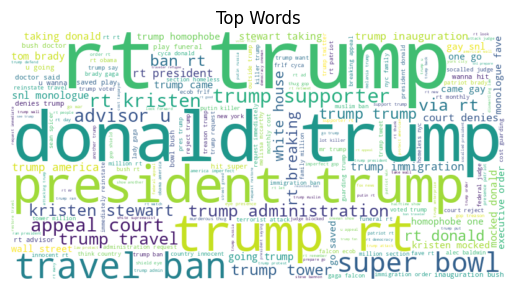

In [ ]:
# Apply cleaning
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Word Cloud
all_words = ' '.join(data['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words")
plt.show()

## 2.** Tokenization** & **Padding** **bold text**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Label Encoding
le = LabelEncoder()
data['Sentiment_encoded'] = le.fit_transform(data['Sentiment'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    data['cleaned_text'], data['Sentiment_encoded'], test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding using 95th percentile
seq_lengths = [len(x) for x in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [ ]:
print("Max sequence length (95th percentile):", max_len)
print("X_train_pad shape:", X_train_pad.shape)
print("X_test_pad shape:", X_test_pad.shape)



Max sequence length (95th percentile): 16
X_train_pad shape: (112509, 16)
X_test_pad shape: (28128, 16)


# **3. Model Building**



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense

vocab_size = 10000
embedding_dim = 128

# Simple RNN
rnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

# LSTM
lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# **4. Training & Evaluation**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile and train function
def compile_and_train(model, name):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(
        X_train_pad, y_train, epochs=10, batch_size=64,
        validation_split=0.2, callbacks=[early_stop], verbose=1)

    preds = (model.predict(X_test_pad) > 0.5).astype("int32")
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
    print("Classification Report:\n", classification_report(y_test, preds))
    return history

# Train both models
history_rnn = compile_and_train(rnn_model, "RNN")
history_lstm = compile_and_train(lstm_model, "LSTM")


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8638 - loss: 0.3067 - val_accuracy: 0.9461 - val_loss: 0.1485
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9697 - loss: 0.0883 - val_accuracy: 0.9494 - val_loss: 0.1449
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9818 - loss: 0.0543 - val_accuracy: 0.9448 - val_loss: 0.1637
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9874 - loss: 0.0388 - val_accuracy: 0.9455 - val_loss: 0.1756
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9917 - loss: 0.0281 - val_accuracy: 0.9464 - val_loss: 0.1821
879/879 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

RNN Accuracy: 0.9446
Confusion Matrix:
 [[17625   824]
 [  735  8944]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     18449
           1       0.92      0.92      0.92      9679

    accuracy                           0.94    

# ** Visualization**

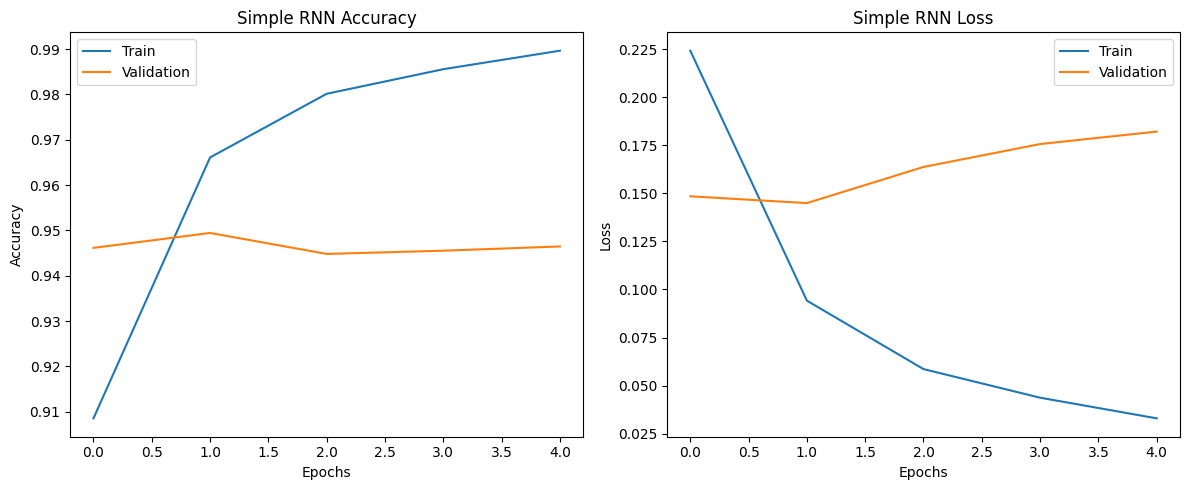

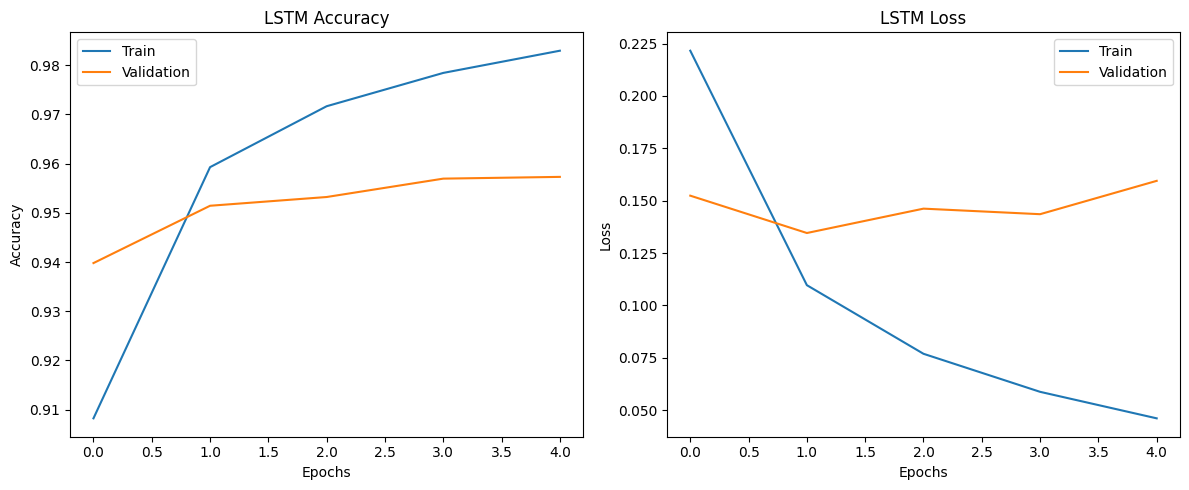

In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

        # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_rnn, "Simple RNN")
plot_history(history_lstm, "LSTM")

 GUI using gradio



> Add blockquote



In [ ]:
# Install Gradio (only needs to run once)
!pip install gradio --quiet

# Import necessary modules
import gradio as gr
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prediction function
def predict_sentiment_gradio(text):
    if not text.strip():
        return "Please enter a tweet!"

    cleaned = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    prediction = lstm_model.predict(padded)[0][0]

    sentiment = 'Positive ' if prediction > 0.5 else 'Negative '
    confidence = f"Confidence: {prediction:.2f}"

    # Add color to the output text
    color = 'green' if prediction > 0.5 else 'red'

    return f"<span style='color:{color}; font-size: 20px;'>{sentiment} ({confidence})</span>"

# Create Gradio interface with custom UI
interface = gr.Interface(
    fn=predict_sentiment_gradio,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Enter a tweet here...",
        label="Tweet Input"
    ),
    outputs=gr.HTML(),  # Output the result as HTML for styling
    title="💬 Twitter Sentiment Analyzer",
    description="Enter a tweet to classify its sentiment as Positive or Negative using an LSTM model.",
    theme="huggingface",  # Use the Huggingface theme or you can use other available themes
    live=True  # Live update as user types
)

# Launch interface
interface.launch()


/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1114: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-6809a1f8-4137b4796ccd29fc6bc76d5b;fbfd7f2d-57b0-4573-82bf-491e9f39ff5b)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a13a5b5ec820c13944.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
